# TODO

```
[ ] Conceptual loss
[ ] KLD loss
```

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [2]:
# hyperparameters
N = 3 # number of bits
k = 2 # base of the bits
tau = 1.
SEED = 1
CUDA = torch.cuda.is_available()
BSIZE = 128

SAVE_FOLDER = 'checkpoint_conceptual_loss'
import os
os.system('mkdir -p {}'.format(SAVE_FOLDER))

0

In [3]:
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

In [4]:
# Transform to binary MNIST
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

# dataset loading
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=BSIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=BSIZE, shuffle=True)

In [5]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    Outputs the hard version, but use soft version's gradients.
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [6]:
HIDDEN_SIZE = 128

def prob(outputs):
    # approx probs of gumble softmax, TODO what is the actual prob?
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    # return bits
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, HIDDEN_SIZE),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.net(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)
    
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1+HIDDEN_SIZE, HIDDEN_SIZE), # input: bit + prev hidden
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.net(x)
    
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        h = self.net(x)
        return h.view(-1,2) # TODO should we do this here?
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        # TODO try same tunnel for encoder and decoder
        # TODO try recurrent
        
        self.ou = nn.ModuleList([Output() for _ in range(N)])
        self.te = nn.ModuleList([Tunnel() for _ in range(N)]) # encoder tunnels
        self.td = nn.ModuleList([Tunnel() for _ in range(N)]) # decoder tunnels
        
    def forward(self, x):
        top_hiddens = [self.encoder(x)] # first is features from the image
        btm_hiddens = [torch.zeros_like(top_hiddens[-1])] # first is dummy input into decoder
        outputs = []
        
        for i in range(N):
            out = self.ou[i](top_hiddens[-1])
            outputs.append(out)
            bit = sample(out)

            top_inp = torch.cat([bit, top_hiddens[-1]], -1)
            top_hiddens.append(self.te[i](top_inp))

            btm_inp = torch.cat([bit, btm_hiddens[-1]], -1)
            btm_hiddens.append(self.td[i](btm_inp))
        
        x_hat = self.decoder(btm_hiddens[-1])
        
        return x_hat
    
    def bits_to_recon(self, bits):
        # NOTE: this is more of a debugging function. TODO Make sure gradients don't get stored.
        init_zeros = Variable(torch.zeros(1, HIDDEN_SIZE))
        if self.is_cuda():
            init_zeros = init_zeros.cuda()
        btm_hiddens = [init_zeros] # first is dummy input into decoder
        
        for i in range(N):
            bit = bits[:,i:i+1]
            btm_inp = torch.cat([bit, btm_hiddens[-1]], -1)
            btm_hiddens.append(self.td[i](btm_inp))
            
        x_hat = self.decoder(btm_hiddens[-1])
        
        return x_hat
    
    def save(self):
        torch.save(self.state_dict(), '{}/net'.format(SAVE_FOLDER))
        
    def is_cuda(self):
        return next(self.parameters()).is_cuda
    
# net = Net()
# net.save()
# _, (data, _) = next(enumerate(train_loader))
# data = Variable(data.view(-1, 784))
# data.shape
# net(data)

In [7]:
# TODO
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)/BSIZE
    
#     # Assuming independent latent
#     KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))
#     # Assuming dependent latent
#     KLD = get_dependent_prior_loss(x)
    return BCE, BCE#, KLD

In [8]:
from itertools import product

def debug():
    f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
    kk = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        w = net.bits_to_recon(make_variable(path))
        ax = axes[kk]
        ax.set_title(path)
        ax.imshow(w.view(28,28).cpu().data.numpy())
        kk += 1
    plt.show()

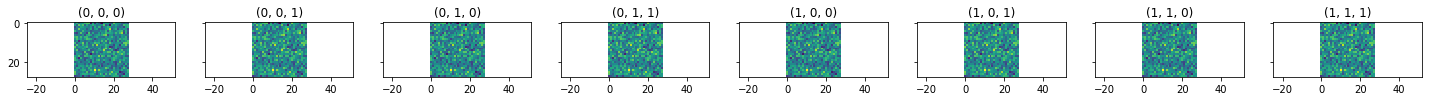

In [9]:
net = Net()
if CUDA:
    net.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=1e-4)
best_loss_sofar = 9999

debug() # test it out

In [10]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        
        recon_x = net(x)
        
#         q = prob(outputs)
        BCE, KLD = loss_function(recon_x, x, None) # TODO
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                BCE.data[0] / len(data),
                KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
        net.save()
        best_loss_sofar = avg_loss
        debug()

Train Epoch: 1 [0/60000 (0%)]	BCE loss: 4.245120	KLD loss: 4.245120
Train Epoch: 1 [25600/60000 (43%)]	BCE loss: 1.609870	KLD loss: 1.609870
Train Epoch: 1 [51200/60000 (85%)]	BCE loss: 1.616619	KLD loss: 1.616619
====> Epoch: 1 Average BCE loss: 2.0760, Average KLD loss: 2.0760, Total: 4.1519
Loss 4.151920356750488 is better than previous best 9999, saving model


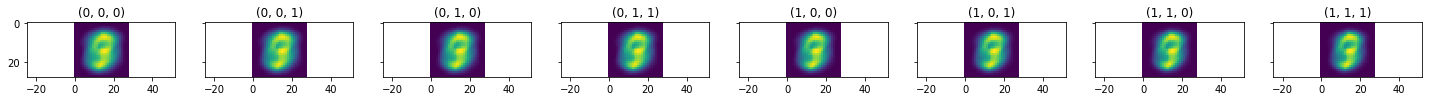

In [11]:
train(0)

Train Epoch: 2 [0/60000 (0%)]	BCE loss: 1.610424	KLD loss: 1.610424
Train Epoch: 2 [25600/60000 (43%)]	BCE loss: 1.530993	KLD loss: 1.530993
Train Epoch: 2 [51200/60000 (85%)]	BCE loss: 1.563102	KLD loss: 1.563102
====> Epoch: 2 Average BCE loss: 1.6111, Average KLD loss: 1.6111, Total: 3.2222
Loss 3.2221835510253904 is better than previous best 4.151920356750488, saving model


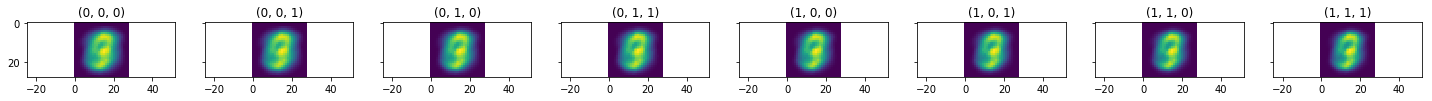

Train Epoch: 3 [0/60000 (0%)]	BCE loss: 1.598374	KLD loss: 1.598374
Train Epoch: 3 [25600/60000 (43%)]	BCE loss: 1.610361	KLD loss: 1.610361
Train Epoch: 3 [51200/60000 (85%)]	BCE loss: 1.593538	KLD loss: 1.593538
====> Epoch: 3 Average BCE loss: 1.6109, Average KLD loss: 1.6109, Total: 3.2218
Loss 3.2218127975463866 is better than previous best 3.2221835510253904, saving model


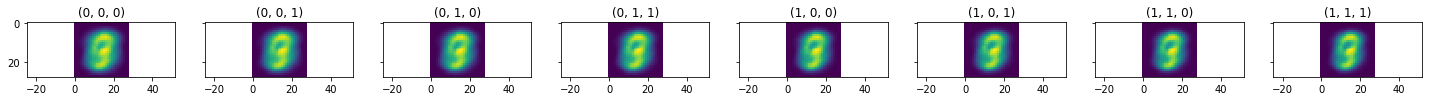

Train Epoch: 4 [0/60000 (0%)]	BCE loss: 1.656310	KLD loss: 1.656310
Train Epoch: 4 [25600/60000 (43%)]	BCE loss: 1.600851	KLD loss: 1.600851
Train Epoch: 4 [51200/60000 (85%)]	BCE loss: 1.556152	KLD loss: 1.556152
====> Epoch: 4 Average BCE loss: 1.6110, Average KLD loss: 1.6110, Total: 3.2219
Train Epoch: 5 [0/60000 (0%)]	BCE loss: 1.607271	KLD loss: 1.607271
Train Epoch: 5 [25600/60000 (43%)]	BCE loss: 1.594052	KLD loss: 1.594052
Train Epoch: 5 [51200/60000 (85%)]	BCE loss: 1.590543	KLD loss: 1.590543
====> Epoch: 5 Average BCE loss: 1.6108, Average KLD loss: 1.6108, Total: 3.2217
Loss 3.221650319925944 is better than previous best 3.2218127975463866, saving model


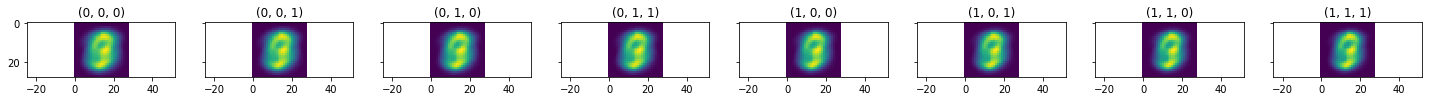

Train Epoch: 6 [0/60000 (0%)]	BCE loss: 1.635788	KLD loss: 1.635788
Train Epoch: 6 [25600/60000 (43%)]	BCE loss: 1.613283	KLD loss: 1.613283
Train Epoch: 6 [51200/60000 (85%)]	BCE loss: 1.656772	KLD loss: 1.656772
====> Epoch: 6 Average BCE loss: 1.6107, Average KLD loss: 1.6107, Total: 3.2214
Loss 3.2214153193155926 is better than previous best 3.221650319925944, saving model


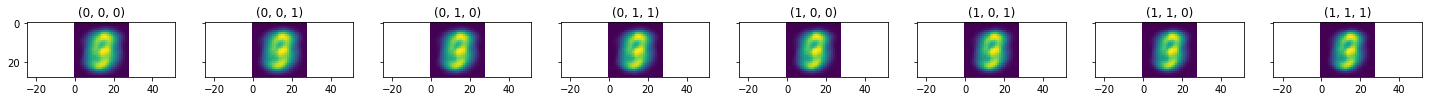

Train Epoch: 7 [0/60000 (0%)]	BCE loss: 1.617002	KLD loss: 1.617002
Train Epoch: 7 [25600/60000 (43%)]	BCE loss: 1.591511	KLD loss: 1.591511
Train Epoch: 7 [51200/60000 (85%)]	BCE loss: 1.619398	KLD loss: 1.619398
====> Epoch: 7 Average BCE loss: 1.6109, Average KLD loss: 1.6109, Total: 3.2217
Train Epoch: 8 [0/60000 (0%)]	BCE loss: 1.620900	KLD loss: 1.620900
Train Epoch: 8 [25600/60000 (43%)]	BCE loss: 1.660276	KLD loss: 1.660276
Train Epoch: 8 [51200/60000 (85%)]	BCE loss: 1.599968	KLD loss: 1.599968
====> Epoch: 8 Average BCE loss: 1.6107, Average KLD loss: 1.6107, Total: 3.2214
Loss 3.221405268351237 is better than previous best 3.2214153193155926, saving model


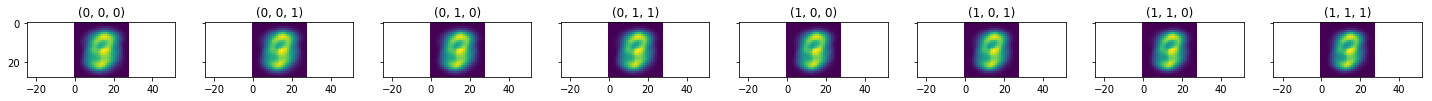

Train Epoch: 9 [0/60000 (0%)]	BCE loss: 1.627880	KLD loss: 1.627880
Train Epoch: 9 [25600/60000 (43%)]	BCE loss: 1.598845	KLD loss: 1.598845
Train Epoch: 9 [51200/60000 (85%)]	BCE loss: 1.615123	KLD loss: 1.615123
====> Epoch: 9 Average BCE loss: 1.6107, Average KLD loss: 1.6107, Total: 3.2214
Loss 3.2214026102701823 is better than previous best 3.221405268351237, saving model


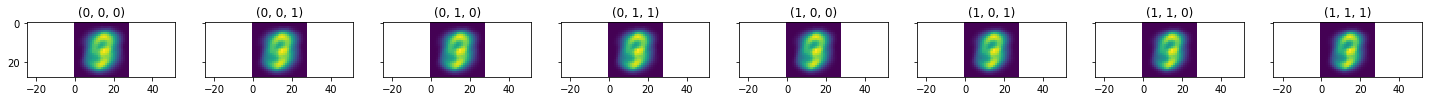

Train Epoch: 10 [0/60000 (0%)]	BCE loss: 1.588799	KLD loss: 1.588799
Train Epoch: 10 [25600/60000 (43%)]	BCE loss: 1.612126	KLD loss: 1.612126
Train Epoch: 10 [51200/60000 (85%)]	BCE loss: 1.593154	KLD loss: 1.593154
====> Epoch: 10 Average BCE loss: 1.6107, Average KLD loss: 1.6107, Total: 3.2214


In [12]:
for i in range(1, 10):
    train(i)